___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8" width="180px" height="180px" />


# <font color= #bbc28d> **Neural Style Transfer** </font>
#### <font color= #2E9AFE> `Project 2 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 12/10/2025.

___

<p style="text-align:right;"> Image retrieved from: https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8</p>

# <font color= #bbc28d> **Libraries and Configuration** </font>

On the requirements.txt file, you can find a list with all the required libraries to run this project. After the libraries are downloaded, we can proceed to import them:

In [ ]:
# Imports

# General Libraries
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Image Modeling and Transformation
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import cv2
import copy

# Graphic Interface
import gradio as gr

Firstly, before running the notebook and executing the models, Pytorch checks if your device has a graphics card available to activate CUDA, which fastens the time required for model training and prediction. If no graphic card is available, Pytorch will run the models on your device CPU.

In [ ]:
# PyTorch Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


# <font color= #bbc28d> **Image Loading** </font>

In [ ]:
size = 512 if torch.cuda.is_available() else 128 # Para que, si no se tiene GPU, las imágenes sean más pequeñas y si puedan cargar
print(size)

# Transformación de imágenes
loader = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

# Función para cargar imágenes fácilmente
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

512


In [138]:
# Example with style image of Picasso and Chilean volcano

style_example = image_loader("style_img/style2.webp")
content_example = image_loader("content/dog.jpeg")

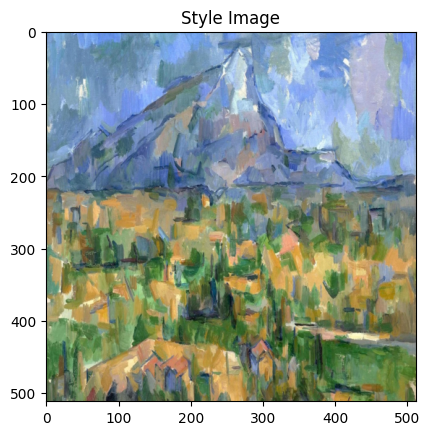

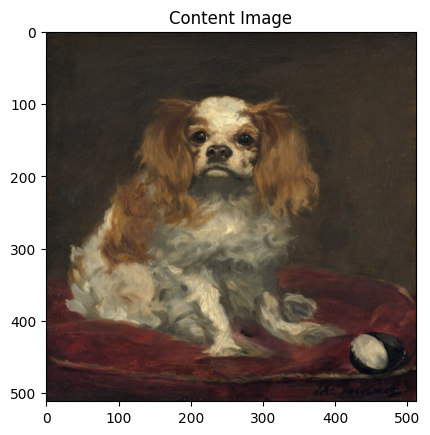

In [139]:
# Pre-visualización de imágenes ya procesadas

to_pil = transforms.ToPILImage()

def show_image(transfomred_image, title=None):
    image = transfomred_image.cpu().clone()
    image = image.squeeze(0)
    image = to_pil(image)

    plt.imshow(image)
    if title is not None:
        plt.title(title)

def show_pil(image, title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
show_image(style_example, title="Style Image")

plt.figure()
show_image(content_example, title="Content Image")

# Loss functions

In [140]:
# Content Loss

class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()

        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [141]:
# Style Loss

def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a*b, c*d)

    G = torch.mm(features, features.t())

    return G.div(a*b*c*d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()

        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importando Modelo

In [142]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

# Normalización de Imágenes para los modelos

In [143]:
# Especificaciones del modelo específico
mean_standard = torch.tensor([0.485, 0.456, 0.406])
std_standard = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
TEXTURE_TEMPLATES = {
    "default": ['conv_1','conv_2','conv_3','conv_4','conv_5'],
    "smooth_1": ['conv_1','conv_2','conv_3','conv_4','conv_5', 'relu_1'],
    "smooth_2": ['conv_1','conv_2','conv_3','conv_4','conv_5', 'relu_1', 'relu_2'],
    "efecto_fino": ['conv_1', 'conv_2'],
    "contraste_fino":['conv1_1', 'relu1_1', 'conv2_1'],
    "enfoque_texturas" : ['conv_4','conv_5']
    }

In [145]:
# Style and content losses

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content, 
                               style_layers, content_layers=['conv_4'], ):
    
    #Normalización
    normalization = Normalization(normalization_mean, normalization_std)

    #Losses
    content_losses = []
    style_losses = []

    # Modelo de normalización
    model = nn.Sequential(normalization)

    i = 0 # Para las diferentes tipos de capas conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        else:
            raise RuntimeError("No se reconoce una capa")
        
        model.add_module(name, layer)

        if name in content_layers:
            # Content Loss
            target = model(content).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # Style Loss
            target = model(style).detach()
            style_loss = StyleLoss(target)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
    
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]

    return model, style_losses, content_losses

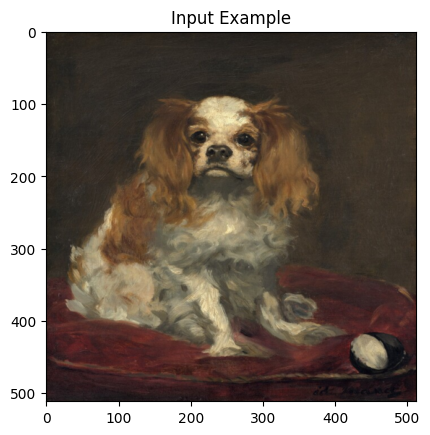

In [146]:
# Input image -> Content Clone

input_example = content_example.clone()

plt.figure()
show_image(input_example, title="Input Example")

# Gradient Descent

In [147]:
def get_input_optimizer(input_image):
    optimizer = optim.LBFGS([input_image])
    return optimizer

In [148]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content, style, input, style_layers, num_steps=300,
                       style_weight = 1e6, content_weight = 1, ):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content, style_layers=style_layers)

    input.requires_grad_(True)
    model.train()
    for i in model.parameters():
        i.requires_grad_(False)

    optimizer = get_input_optimizer(input)

    run = [0]

    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward(retain_graph=True)

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'Run {run[0]}')
                print(f'Style Loss: {style_score:4f}. Content Loss: {content_score:4f}')

                return style_score + content_score
            
            return loss
            
        optimizer.step(closure)

    with torch.no_grad():
        input.clamp_(0, 1)
    
    return input

In [ ]:
# Color transfer

def tensor_to_pil(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = to_pil(image)
    return image

def transfer_color(content_image, style_image, output_image, mode):
    content = np.array(content_image.convert('RGB'), dtype=np.uint8) 
    style = np.array(style_image.convert('RGB'), dtype=np.uint8)
    output = np.array(output_image.convert('RGB'), dtype=np.uint8)

    # Converting to YUV (PAL Color Standard)
    yuv_content = cv2.cvtColor(content, cv2.COLOR_RGB2YUV)
    yuv_style = cv2.cvtColor(style, cv2.COLOR_RGB2YUV)
    yuv_output = cv2.cvtColor(output, cv2.COLOR_RGB2YUV)

    # Color selection
    if mode == "content":
        yuv_output[:,:,1:] = yuv_content[:,:,1:]
    
    elif mode == "original":
        
        # Regresa la imagen tal cual, sin cambios
        return output_image
        
    else:
        yuv_output[:,:,1:] = yuv_style[:,:,1:]
    
    final_image = cv2.cvtColor(yuv_output, cv2.COLOR_YUV2RGB)
    
    return Image.fromarray(np.uint8(final_image))

    

c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Run 50
Style Loss: 1395.294189. Content Loss: 16.732012
Run 100
Style Loss: 78.363976. Content Loss: 12.748564
Run 150
Style Loss: 24.221958. Content Loss: 11.736819
Run 200
Style Loss: 8.441753. Content Loss: 10.098933
Run 250
Style Loss: 3.140698. Content Loss: 8.680593
Run 300
Style Loss: 1.556210. Content Loss: 7.550523


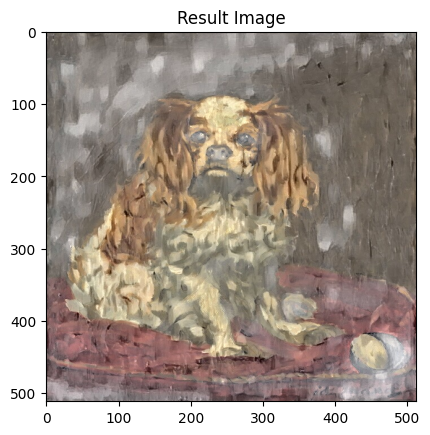

In [151]:
model_output = run_style_transfer(cnn, mean_standard, std_standard, content_example, style_example, input_example, style_layers=TEXTURE_TEMPLATES['default'])

content_pil = tensor_to_pil(content_example)
style_pil = tensor_to_pil(style_example)
output_pil = tensor_to_pil(model_output)

final_image = transfer_color(content_pil, style_pil, output_pil, mode="content")

plt.figure()
show_pil(final_image, title="Result Image")

# <font color= #bbc28d> **Model Control** </font>

In [ ]:
def image_style_transfer(content_img, style_img, style_percent, color, texture):
    
    # Cargando imagenes
    content_image = image_loader(content_img)
    style_image = image_loader(style_img)
    input_image = content_image.clone()

    model_output = run_style_transfer(cnn, mean_standard, std_standard, content_image, style_image, 
                                      input_image, style_layers=TEXTURE_TEMPLATES[texture], num_steps=300, style_weight=style_percent * 10000, content_weight=1)

    content_pil = tensor_to_pil(content_image)
    style_pil = tensor_to_pil(style_image)
    output_pil = tensor_to_pil(model_output)

    final_image = transfer_color(content_pil, style_pil, output_pil, mode=color)

    return final_image

demo = gr.Interface(image_style_transfer, inputs=[gr.Image(type='filepath'),
                                                  gr.Image(type='filepath'), 
                                                  gr.Slider(0, 100 ,label="Estilo", info="Cuánto estilo le quieres meter a la imagen?", value=100),
                                                  gr.Radio(["content",'style'], label="Color", info="Quieres el color del estilo (style) o mantener el original (content)?"),
                                                  gr.Radio(['default', 'smooth_1', 'smooth_2', 'efecto_fino', 'contraste_fino', 'enfoque_texturas'], label="Textura", info="Decide entre 6 configuraciones de textura/efectos")],
                    outputs= ["image"])
demo.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\fastapi\applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\pixta\miniconda3\envs\machine\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise

Run 50
Style Loss: 219.780930. Content Loss: 14.150992
Run 100
Style Loss: 68.744713. Content Loss: 12.579638
Run 150
Style Loss: 21.503147. Content Loss: 11.560948
Run 200
Style Loss: 7.996405. Content Loss: 10.096228
Run 250
Style Loss: 2.967286. Content Loss: 8.606508
Run 300
Style Loss: 1.483934. Content Loss: 7.461575
